---
# First Use Case - Total Regional Sample of all patent classes
---

<a id="top"></a>
# Text Analysis, Keyword extraction and Topic Modelling
Using Abstracts from the patstat data set we aim to extract essential keywords which will act as suitable identifiers for Patents several fields. This will aid us in identifying regional knowledge bases and research hubs in a more automated fashion, at the moment keywords used for the search are suggested by experts. We will use a variety of approaches rooted in the research field of Natural Language Processing (NLP) and Textual Analysis as well as statistical modelling approaches which include:
- Latent Dirichlet Allocation
- Latent Semantiv Analysis
- Negative Matrix Factorization
- Uniform Manifold Approximation and Projection for Dimension Reduction

This notebook follows a variety of online and printed sources which will be credited in the [bibliography](#bibl).
***

# Table of Content

1. [Get and prepare the data](#chap1)
2. [Vectorizer](#chap3)
3. [Topic Modelling](#chap4)
4. [Results and visualisations](#chap5)

# 1. Get and prepare the data
<a id="chap1"></a>
Here we focus on importing the data from the data base, introducing stopwords, stemming and lemmatization (even though we prioritized lemmatization) using part-of-speech tagging (pos tagging) to improve the lemmatization quality, we could construct some features regarding length, number of words or stopwords as suggested in [1].

In [1]:
# load packages
import numpy as np
import pandas as pd
import pickle
import nltk
import psycopg2 as db
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

In [2]:
# necessary packages for [10]
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# defining stopwords and the lemmatizer based on: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
stop_words = nltk.corpus.stopwords.words('english')

stop_words.extend(['overall','result','end','likewise','present','method','invention','relates','also','lastly',
                       'firstly','include', 'includes', 'including','exclude','desired','according','embodiments','first','least',
                       'configured','time','certain','therefor','whose','receiving','following','steps','using','use','individual',
                       'needed','need','purpose','profile','n','said','may','wherein','target','determining','set','comprises',
                       '1','2','10','comprising','provide','provided','used','means','proceeded','proceed','one','two','second', '100', 'preferably',
                       'problem','to','be','solved','solution','jpo','ncipi','problems','means','for','solving','utility','discloses','provides',
                        '<id>','</id>','<br>','</br>','<p>','</p>','<ul>','</ul>','<ol>','</ol>','<li>','</li>','<p id=','num=',
                        '<img id=','file='])

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


# Init Lemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [8]:
# establish connection and read data from postgres
# source: https://pynative.com/python-postgresql-tutorial/
try:
    connection = db.connect(user = XXX,
                                  password = XXX,
                                  host = XXX,
                                  port = XXX,
                                  database = XXX)
    #connection.set_client_encoding('UTF8')
    cursor = connection.cursor()
    # 19 mio distinct abstracts, some are in there multiple times because of multiple ipcs (32mio)
    # with c08 the total is about 5mio
    cursor.execute("SELECT * from thesis.regional_abstracts WHERE appln_abstract_lg = 'en' and LENGTH(nuts) > 2")
    returnlist = []
    row = cursor.fetchone()
    returnlist.append(row)
    errorcnt = 0
    while row is not None:
        try:
            row = cursor.fetchone()
            if row is not None:
                #row['appln_abstract'] = stem.stemabstract(row['appln_abstract'])
                returnlist.append(row)
        except UnicodeDecodeError:
            errorcnt = errorcnt + 1
    print("Couldn't decode " + str(errorcnt) + " abstracts")
    record = returnlist
except (Exception, db.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

Couldn't decode 9 abstracts
PostgreSQL connection is closed


In [5]:
len(record)

34018

In [7]:
id2word = corpora.Dictionary([[]])
print(id2word)

Dictionary(0 unique tokens: [])


In [8]:
# create a corpus
def makecorpus(record,stop_words):
    phrases = nltk.tokenize.sent_tokenize(record)
    #words = nltk.tokenize.word_tokenize(record)
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(record)
    # stopwords
    #stop_words = stop_words
    corpus = [] 
    for w in words:
        if not w.isnumeric():
            if len(w) > 2:
                if w.lower() not in stop_words: 
                    # because of the need to compare each entry to wordnet lemmatizer takes ages
                    #token = stemmer.stem(w.lower())
                    token = (lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w)))
                    id2word.add_documents([[token]])
                    corpus.append(token)
    return corpus

In [9]:
# need to be able to perform this batchwise
corpuslist = []

for i in range(0, len(record)):
    dat = str(record[i][2]) # extract the column containing the abstract
    corpuslist.append(makecorpus(dat,stop_words))

In [11]:
print(id2word)

Dictionary(14201 unique tokens: ['cover', 'woven', 'layer', 'join', 'connect']...)


In [18]:
# optional
#id2word.filter_extremes(no_below=5, no_above=0.95)#, keep_n=1000000)

In [13]:
print(id2word)

Dictionary(14201 unique tokens: ['cover', 'woven', 'layer', 'join', 'connect']...)


In [12]:
sentences = [record[i][2] for i in range(0,len(record))]

In [13]:
appids = [record[i][0] for i in range(0,len(record))]

In [14]:
ipcs = [record[i][4][0:4] for i in range(0,len(record))]

In [15]:
nuts = [record[i][6] for i in range(0,len(record))]

In [16]:
ctr = [record[i][7] for i in range(0,len(record))]

In [48]:
tokenslist = [','.join(corpuslist[i]) for i in range(0,len(corpuslist))]

In [20]:
del record

# 2. Vectorizers
<a id="chap3"></a>
We start by applying a simple bag of words vectorizer but will also use a tfidf weighted matrix. A one hot encoder would not proof beneficial for the approach at hand.

In [20]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in corpuslist]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 7), (5, 6), (6, 2), (7, 3), (8, 5), (9, 4), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 3), (34, 1), (35, 2), (36, 1), (37, 2), (38, 3), (39, 1), (40, 4), (41, 1), (42, 1), (43, 1), (44, 1)]]


In [23]:
from gensim.models import TfidfModel

model = TfidfModel(corpus)  # fit model
tfidf_matrix = model[corpus]

In [24]:
# using the sklearn implementation based on https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created
def dummy_fun(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None) #, ngram_range=(1,1), max_features=10000, max_df=.9)

X_train_tfidf = tfidf_vectorizer.fit_transform(corpuslist)
# get the first vector out (for the first document)
first_vector_tfidfvectorizer = X_train_tfidf[0]

# 3. Topic Modelling
<a id="chap4"></a>
We want to classify an abstract based on their content. Topic modeling provides us with methods to organize, understand and summarize large collections of textual information. We will use a variety of approaches including LDA, NMF, LSA and UMAP in combination with general purpose classification (HDBSCAN and kmeans).


## 3.1. LDA
Latent Dirichlet Allocation is one of the key models in this domain. LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

![title](topical.png)

In [25]:
# hyperparameter tuning according to https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_matrix,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=7000,
                                           passes=5,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True
                                           ) # topics 15
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
    perp = lda_model.log_perplexity(tfidf_matrix)
    return coherence_model_lda.get_coherence(), perp

We perform grid search on the LDA model to find the best parameterization, we will use the number of topics for the other topic models as well.

In [110]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))#
               corpus]
corpus_title = ['Entire Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }


# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    result = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(result[0])
                    model_results['Perplexity'].append(result[1])
                pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)

Text(0.5, 1.0, 'Model Selection - Number of Topics')

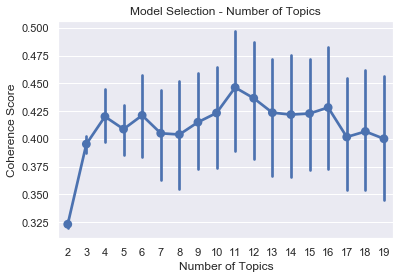

In [32]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.pointplot(x="Topics", y="Coherence", data=model_results)
ax.set(xlabel='Number of Topics', ylabel='Coherence Score')
ax.set_title("Model Selection - Number of Topics")

In [33]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_matrix,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=7000,
                                           passes=5,
                                           per_word_topics=True,
                                           alpha=0.01,
                                           eta = 0.31
                                           ) # topics 15

In [34]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=15))
#doc_lda = lda[corpus]

[(0,
  '0.014*"group" + 0.009*"acid" + 0.007*"compound" + 0.005*"alkyl" + '
  '0.005*"resin" + 0.005*"coat" + 0.005*"isocyanate" + 0.004*"water" + '
  '0.004*"unsaturated" + 0.004*"formula" + 0.004*"aqueous" + '
  '0.004*"polyurethane" + 0.004*"amine" + 0.004*"polymer" + 0.004*"atom"'),
 (1,
  '0.018*"signal" + 0.008*"output" + 0.007*"voltage" + 0.007*"input" + '
  '0.007*"circuit" + 0.007*"sensor" + 0.007*"current" + 0.006*"terminal" + '
  '0.006*"switch" + 0.004*"value" + 0.004*"control" + 0.004*"converter" + '
  '0.004*"transistor" + 0.004*"generate" + 0.004*"couple"'),
 (2,
  '0.023*"battery" + 0.015*"layer" + 0.012*"cell" + 0.011*"electrically" + '
  '0.010*"substrate" + 0.009*"module" + 0.009*"carrier" + '
  '0.008*"semiconductor" + 0.008*"component" + 0.007*"conductive" + '
  '0.007*"structure" + 0.006*"contact" + 0.006*"surface" + 0.006*"circuit" + '
  '0.006*"plurality"'),
 (3,
  '0.008*"layer" + 0.005*"mold" + 0.004*"antigen" + 0.004*"composite" + '
  '0.004*"fabric" + 0.004*

In [35]:
print('\nPerplexity:', lda_model.log_perplexity(tfidf_matrix))

coherence_score_lda = CoherenceModel(model=lda_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


Perplexity: -8.630583394968644

Coherence Score: 0.59224124385403


In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_matrix, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.142498 -0.144442       1        1  36.251301
0     -0.192316 -0.002833       2        1  11.214119
7     -0.085238 -0.063451       3        1   9.686400
5      0.076423 -0.013403       4        1   8.796407
10    -0.161085 -0.050051       5        1   7.709551
1      0.031421  0.145870       6        1   6.505906
2      0.102279 -0.029074       7        1   5.345256
8      0.070405  0.006856       8        1   4.856728
4      0.059181  0.107579       9        1   4.430215
3      0.001714  0.022913      10        1   2.942235
6     -0.045283  0.020035      11        1   2.261880, topic_info=               Term        Freq       Total Category  logprob  loglift
751         battery  239.000000  239.000000  Default  30.0000  30.0000
2             layer  472.000000  472.000000  Default  29.0000  29.0000
341   polypropylene  238.000000  238.000000  Default  28.0000  28.0000
342     composition  335.000000  335.000000  Default  27.0000  27.0000
489           valve  252.000000  252.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2079         filter    9.753119  141.789398  Topic11  -5.8720   1.1122
1745          stack    8.462611   83.233620  Topic11  -6.0139   1.5030
365            film    9.407605  180.485794  Topic11  -5.9081   0.8348
546         product    8.803508  170.111725  Topic11  -5.9745   0.8277
353         produce    8.525921  169.690262  Topic11  -6.0065   0.7981

[712 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2103       5  0.946704    10min
13822      4  0.807299     172a
2939       3  0.834471      3cb
2940       3  0.834471    3dgeo
8264      11  0.620331      3rd
...      ...       ...      ...
13698      3  0.831308      xvo
919        2  0.030671   xylene
919        5  0.920125   xylene
2941       3  0.834471      yeu
3344       5  0.848019  ziegler

[2799 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 8, 6, 11, 2, 3, 9, 5, 4, 7])

In [42]:
# look at the degree of assosciation
lda_model[corpus[60]] # corpus[0] means the first document.

([(2, 0.6895162), (5, 0.20415942), (9, 0.10446798)],
 [(11, [2, 9, 5]),
  (45, [2, 9, 5]),
  (46, [2, 5, 9]),
  (52, [5, 2, 9]),
  (62, [2, 9, 5]),
  (94, [2, 9, 5]),
  (112, [2, 5, 9]),
  (121, [2, 5, 9]),
  (122, [2, 5, 9]),
  (274, [2, 9]),
  (313, [5, 2, 9]),
  (397, [2, 5, 9]),
  (398, [5, 2, 9]),
  (399, [2, 5]),
  (400, [2, 9, 5]),
  (401, [2, 5, 9]),
  (402, [2, 9]),
  (403, [2, 9]),
  (404, [2, 5, 9]),
  (405, [2, 5, 9]),
  (406, [2, 5, 9]),
  (407, [2, 9])],
 [(11, [(2, 1.6103023), (5, 0.19393075), (9, 0.19570753)]),
  (45, [(2, 2.9865189), (5, 0.33717945), (9, 0.67617315)]),
  (46, [(2, 0.47692564), (5, 0.35885003), (9, 0.16410229)]),
  (52, [(2, 0.68886834), (5, 0.7655752), (9, 0.5453884)]),
  (62, [(2, 3.9505994), (5, 0.018059373), (9, 0.03126803)]),
  (94, [(2, 0.49015087), (5, 0.1253989), (9, 0.3843426)]),
  (112, [(2, 2.381514), (5, 0.51673335), (9, 0.101658806)]),
  (121, [(2, 0.47344986), (5, 0.35818794), (9, 0.16823909)]),
  (122, [(2, 0.49029619), (5, 0.34827176), (

## 3.2. NMF Model

In [146]:
from gensim.models.nmf import Nmf

nmf = Nmf(corpus=tfidf_matrix,
    id2word=id2word,
    num_topics=11,
    chunksize=2000,
    passes=5,
    random_state=42,
    normalize=True
)

D:\katzn\Anaconda\lib\site-packages\gensim\models\nmf.py:588: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(corpus, collections.Iterator) and self.passes > 1:


In [147]:
nmf.show_topics(num_topics=11,num_words=15,formatted=False)

[(0,
  [('drive', 0.02634284947798128),
   ('shaft', 0.020586126024686978),
   ('wheel', 0.016243089481749372),
   ('gear', 0.01501823707714107),
   ('unit', 0.01289411888284711),
   ('motor', 0.012520830932691022),
   ('clutch', 0.012291459831074244),
   ('control', 0.00916547538506368),
   ('machine', 0.009147933190465309),
   ('housing', 0.008837889607394886),
   ('vehicle', 0.008362578247114958),
   ('frame', 0.00763562935130717),
   ('connect', 0.007261040150483538),
   ('transmission', 0.0070376311074476505),
   ('torque', 0.006983177359683136)]),
 (1,
  [('signal', 0.014775299753283434),
   ('roll', 0.012793774919317009),
   ('sensor', 0.011934895201687555),
   ('measure', 0.011559468440503994),
   ('container', 0.010530785859923078),
   ('unit', 0.01038663672368695),
   ('device', 0.009344415639638271),
   ('sample', 0.007012583152976156),
   ('value', 0.006493914031135021),
   ('control', 0.00634114533074618),
   ('data', 0.006194526129211185),
   ('measurement', 0.00590042891

In [148]:

coherence_score_nmf = CoherenceModel(model=nmf, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_nmf.get_coherence()

print('\nCoherence Score:', coherence_score)
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


Coherence Score: 0.6301046483365922


## 3.3. LSA

In [51]:
lsi_model = LsiModel(corpus, num_topics=11, id2word=id2word)
pprint(lsi_model.print_topics(num_words=20))

[(0,
  '0.361*"device" + 0.221*"element" + 0.209*"material" + 0.208*"form" + '
  '0.190*"part" + 0.166*"unit" + 0.164*"surface" + 0.151*"gas" + '
  '0.145*"connect" + 0.142*"layer" + 0.142*"position" + 0.137*"arrange" + '
  '0.126*"support" + 0.116*"guide" + 0.114*"control" + 0.105*"component" + '
  '0.102*"side" + 0.095*"process" + 0.088*"direction" + 0.087*"cool"'),
 (1,
  '0.289*"group" + -0.276*"device" + 0.243*"material" + 0.210*"layer" + '
  '0.197*"contain" + 0.191*"acid" + 0.190*"gas" + 0.163*"compound" + '
  '-0.160*"guide" + -0.148*"slab" + 0.143*"water" + -0.131*"position" + '
  '-0.131*"strand" + 0.126*"process" + -0.105*"element" + -0.105*"cast" + '
  '0.102*"optionally" + 0.100*"copolymer" + 0.097*"composition" + '
  '0.095*"melt"'),
 (2,
  '-0.339*"slab" + -0.287*"device" + 0.255*"part" + -0.219*"gas" + '
  '-0.218*"cast" + 0.206*"element" + -0.199*"guide" + -0.198*"roll" + '
  '-0.191*"strand" + 0.177*"surface" + -0.161*"thickness" + 0.157*"layer" + '
  '-0.133*"speed" 

In [52]:
coherence_score_lsi = CoherenceModel(model=lsi_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lsi.get_coherence()

print('\nCoherence Score:', coherence_score)


Coherence Score: 0.3821312558318868


## 3.4. UMAP

In [58]:
# UMAP
import seaborn as sns
import umap
sns.set(style='white', rc={'figure.figsize':(10,8)})
standard_embedding = umap.UMAP(metric='hellinger',low_memory=True, init='random',
                               random_state=100).fit_transform(X_train_tfidf)

In [82]:
clusterable_embedding = umap.UMAP(
    n_neighbors=250, # high for clusters
    low_memory=True,
    min_dist=0.01, #low for cluster
    #init='random',
    n_components=25,
    random_state=42
).fit_transform(X_train_tfidf)

In [27]:
import hdbscan
labels = hdbscan.HDBSCAN(
    min_samples=15,
    min_cluster_size=350,
).fit_predict(clusterable_embedding)

D:\katzn\Anaconda\lib\site-packages\joblib\parallel.py:299: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
D:\katzn\Anaconda\lib\site-packages\joblib\parallel.py:299: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
D:\katzn\Anaconda\lib\site-packages\joblib\parallel.py:299: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
D:\katzn\Anaconda\lib\site-packages\joblib\parallel.py:299: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [51]:
clusterer = pd.DataFrame(list(zip(tokenslist, ipcs, labels.tolist())), 
               columns =['sentences', 'ipc','group'], index=appids) 


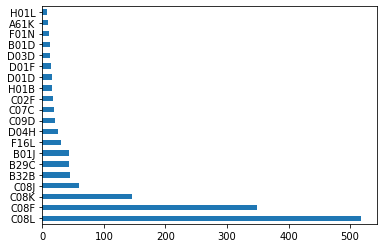

In [65]:
clusterer[clusterer["group"]==4]['ipc'].value_counts()[:20].plot(kind='barh')

In [125]:
import sklearn.cluster as cluster
kmeans_labels = cluster.KMeans(n_clusters=11).fit_predict(clusterable_embedding)

In [127]:
kmclusterer = pd.DataFrame(list(zip(tokenslist, ipcs, kmeans_labels.tolist())), 
               columns =['sentences', 'ipc','group'], index=appids) 

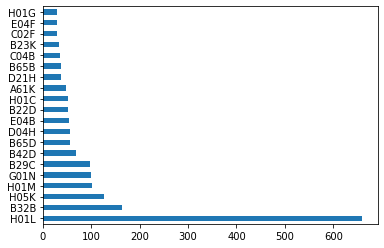

In [138]:
kmclusterer[kmclusterer["group"]==10]['ipc'].value_counts()[:20].plot(kind='barh')

In [139]:
mytest = kmclusterer.groupby('group')['sentences'].apply(','.join).reset_index()

In [140]:
umaplisting = list()
for i in range(0,11):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(mytest['sentences'][i])
    umaplisting.append(words)

Check the most important terms for each topic. This routine yields comparable results to the top term list provided by the classical topic models

In [236]:
# TFIDF to get the most "important" terms of each abstract
# inspired by source: https://stevenloria.com/tf-idf/
import math
def tf(term, doc):
    return doc.count(term) / len(doc)
    
def n_containing(term):
    res = 0
    for i in range(0,11):
        if any(term in item for item in umaplisting[i]):
            res = res + 1
    return res

def idf(term, list):
    return math.log(len(list)) / (1+n_containing(term))


def tfidf(term, doc, list):
    return tf(term, doc) * idf(term, list)

for i, value in enumerate(umaplisting):
    print("Top words in document {}".format(i + 1))
    scores = {term: tfidf(term, umaplisting[i], umaplisting) for term in umaplisting[i]}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for term, score in sorted_words[:10]:
        print("\tWord: {}, TF-IDF: {}".format(term, round(score, 5)))

Top words in document 1
	Word: clutch, TF-IDF: 0.00753
	Word: torque, TF-IDF: 0.00624
	Word: medication, TF-IDF: 0.00548
	Word: engine, TF-IDF: 0.00407
	Word: valve, TF-IDF: 0.00385
	Word: control, TF-IDF: 0.00337
	Word: torch, TF-IDF: 0.00318
	Word: element, TF-IDF: 0.00293
	Word: laser, TF-IDF: 0.00283
	Word: vehicle, TF-IDF: 0.00259
Top words in document 2
	Word: copolymer, TF-IDF: 0.00529
	Word: composition, TF-IDF: 0.00492
	Word: polypropylene, TF-IDF: 0.00437
	Word: propylene, TF-IDF: 0.00424
	Word: heterophasic, TF-IDF: 0.00386
	Word: olefin, TF-IDF: 0.00295
	Word: polymer, TF-IDF: 0.00278
	Word: ethylene, TF-IDF: 0.00222
	Word: melt, TF-IDF: 0.00221
	Word: reactor, TF-IDF: 0.00198
Top words in document 3
	Word: signal, TF-IDF: 0.00426
	Word: circuit, TF-IDF: 0.00329
	Word: device, TF-IDF: 0.00276
	Word: sensor, TF-IDF: 0.00244
	Word: control, TF-IDF: 0.00234
	Word: battery, TF-IDF: 0.00218
	Word: switch, TF-IDF: 0.00209
	Word: terminal, TF-IDF: 0.00204
	Word: data, TF-IDF: 0.00

# 4. Results and Visualisations
<a id="chap5"></a>
The last section visualizes the results from our final model (NMF in this case). We will look at the technological concetration (dominant regional cluster compared to the general corpus cluster distribution) and relevant peer regions. We will also look at some abstracts using tagging and highlighting and create maps which will highlight peer regions.

In [161]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=sentences, ids=appids, ipcs=ipcs, ctr=ctr, nuts=nuts):
    # Init output
    sent_topics_df = pd.DataFrame()
    sent_topics_list = []
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        #row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #print(round(prop_topic,4))
                sent_topics_list.append([int(topic_num),round(prop_topic,4),topic_keywords])
            else:
                break
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df=pd.DataFrame(sent_topics_list,columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    contents = pd.Series(texts[0:len(corpus)])
    appid = pd.Series(ids[0:len(corpus)])
    ipcs = pd.Series(ipcs[0:len(corpus)])
    ctr = pd.Series(ctr[0:len(corpus)])
    nuts = pd.Series(nuts[0:len(corpus)])
    sent_topics_df = pd.concat([sent_topics_df, contents,appid,ipcs,ctr,nuts], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=nmf, corpus=corpus, texts=sentences, ids=appids,ipcs=ipcs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','ids','ipcs','ctr','nuts']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0              10              0.3118   
1            1              10              0.4998   
2            2              10              0.8238   
3            3               2              0.5732   
4            4               2              0.5450   
5            5               2              0.5462   
6            6              10              0.3448   
7            7               2              0.3695   
8            8               2              0.3561   
9            9               2              0.3652   

                                            Keywords  \
0  part, element, wall, frame, support, body, sid...   
1  part, element, wall, frame, support, body, sid...   
2  part, element, wall, frame, support, body, sid...   
3  plate, section, surface, press, light, carrier...   
4  plate, section, surface, press, light, carrier...   
5  plate, section, surface, press, light, carrier...   
6  part, element, wall, frame, support, body, sid...   
7  plate, section, surface, press, light, carrier...   
8  plate, section, surface, press, light, carrier...   
9  plate, section, surface, press, light, carrier...   

                                                Text  ids  ipcs ctr   nuts  
0  The covering comprises woven layers joined by ...   83  D21F  AT  AT313  
1  The element is included in a wall having openi...  163  E01F  AT  AT213  
2  The end i.e. front module, has an energy absor...  208  B60R  AT  AT221  
3  The advertising media has two opposite cover s...  267  G09F  AT  AT312  
4  The advertising media has two opposite cover s...  267  G09F  AT  AT312  
5  The advertising media has two opposite cover s...  267  G09F  AT  AT312  
6  Shut-off system comprises a plate-like shut-of...  537  F16K  AT  AT315  
7  The device has a feeder (2) for goods flow to ...  650  B03B  AT  AT314  
8  The device has a feeder (2) for goods flow to ...  650  B07B  AT  AT314  
9  The device has a feeder (2) for goods flow to ...  650  B07B  AT  AT314

In [234]:
group = 3
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['Keywords'].iloc[0]

'gas, valve, exhaust, engine, cylinder, inlet, control, brake, air, pressure'

In [230]:
group = 1
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group].sort_values(by=['Topic_Perc_Contrib']).tail(20)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
4093          4093               1                 1.0   
33349        33349               1                 1.0   
33350        33350               1                 1.0   
33351        33351               1                 1.0   
22365        22365               1                 1.0   
30207        30207               1                 1.0   
30199        30199               1                 1.0   
30198        30198               1                 1.0   
33376        33376               1                 1.0   
33377        33377               1                 1.0   
33378        33378               1                 1.0   
29829        29829               1                 1.0   
33400        33400               1                 1.0   
29828        29828               1                 1.0   
29827        29827               1                 1.0   
4090          4090               1                 1.0   
4091          4091               1                 1.0   
4092          4092               1                 1.0   
22308        22308               1                 1.0   
34001        34001               1                 1.0   

                                                Keywords  \
4093   signal, roll, sensor, measure, container, unit...   
33349  signal, roll, sensor, measure, container, unit...   
33350  signal, roll, sensor, measure, container, unit...   
33351  signal, roll, sensor, measure, container, unit...   
22365  signal, roll, sensor, measure, container, unit...   
30207  signal, roll, sensor, measure, container, unit...   
30199  signal, roll, sensor, measure, container, unit...   
30198  signal, roll, sensor, measure, container, unit...   
33376  signal, roll, sensor, measure, container, unit...   
33377  signal, roll, sensor, measure, container, unit...   
33378  signal, roll, sensor, measure, container, unit...   
29829  signal, roll, sensor, measure, container, unit...   
33400  signal, roll, sensor, measure, container, unit...   
29828  signal, roll, sensor, measure, container, unit...   
29827  signal, roll, sensor, measure, container, unit...   
4090   signal, roll, sensor, measure, container, unit...   
4091   signal, roll, sensor, measure, container, unit...   
4092   signal, roll, sensor, measure, container, unit...   
22308  signal, roll, sensor, measure, container, unit...   
34001  signal, roll, sensor, measure, container, unit...   

                                                    Text        ids  ipcs ctr  \
4093   The arrangement has a comparator (K1) that com...   15906649  H04L  AT   
33349  The invention discloses a method for measuring...  474003875  G01N  AT   
33350  The invention discloses a method for measuring...  474003875  G01N  AT   
33351  The invention discloses a method for measuring...  474003875  G01N  AT   
22365  In an incremental measuring system a measuring...   51540380  G01D  AT   
30207  The present invention relates to a method, app...  405371066  G08G  AT   
30199  A sensor amplifier arrangement (10) includes a...  405108832  H03F  AT   
30198  A sensor amplifier arrangement (10) includes a...  405108832  H03F  AT   
33376  A signal processing arrangement for a Hall sen...  474555132  G01R  AT   
33377  A signal processing arrangement for a Hall sen...  474555132  H03M  AT   
33378  A signal processing arrangement for a Hall sen...  474555132  H03M  AT   
29829  The method involves dividing a biological sign...  380623617  A61B  AT   
33400  A time-to-digital converter system has at leas...  475055247  G04F  AT   
29828  The method involves dividing a biological sign...  380623617  A61B  AT   
29827  The method involves dividing a biological sign...  380623617  A61B  AT   
4090   The arrangement has a comparator (K1) that com...   15906649  H03K  AT   
4091   The arrangement has a comparator (K1) that com...   15906649  H03K  AT   
4092   The arrangement has a comparator (K1) that com...   15906649  

In [231]:
j = 34001
sentences[j]

'A sensor amplifier arrangement includes an amplifier having a signal input to receive a sensor signal and a signal output to provide an amplified sensor signal, and a feedback path that couples the signal output to the signal input and provides a feedback current that is an attenuated signal of the amplified sensor signal and is inverted with respect to the sensor signal.'

In [232]:
for i in id2word.doc2idx(corpuslist[j]):
    print(id2word[i])
    print(nmf.get_term_topics(i,minimum_probability = .3))

sensor
[(1, 0.6150352094684582), (7, 0.38496479053154176)]
amplifier
[(1, 0.648147066293321)]
arrangement
[(1, 0.3770580921785403)]
amplifier
[(1, 0.648147066293321)]
signal
[(1, 0.886793457388781)]
input
[(0, 0.5042842482576787), (1, 0.36928107644719804)]
receive
[(1, 0.8247008381825046)]
sensor
[(1, 0.6150352094684582), (7, 0.38496479053154176)]
signal
[(1, 0.886793457388781)]
signal
[(1, 0.886793457388781)]
output
[(0, 0.5516592242572697)]
amplify
[(1, 0.8993330062892577)]
sensor
[(1, 0.6150352094684582), (7, 0.38496479053154176)]
signal
[(1, 0.886793457388781)]
feedback
[(1, 0.3155926340924268), (3, 0.6844073659075731)]
path
[(1, 0.37937223062854436)]
couple
[(0, 0.6315964050948923)]
signal
[(1, 0.886793457388781)]
output
[(0, 0.5516592242572697)]
signal
[(1, 0.886793457388781)]
input
[(0, 0.5042842482576788), (1, 0.3692810764471981)]
feedback
[(1, 0.3155926340924268), (3, 0.6844073659075731)]
current
[(7, 0.3603156997933504)]
attenuate
[(1, 0.8188623985182562)]
signal
[(1, 0.88679

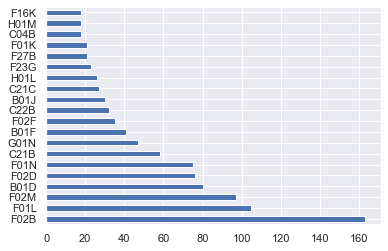

In [235]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['ipcs'].value_counts()[:20].plot(kind='barh')


In [213]:
domipcs = pd.DataFrame(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['ipcs'].value_counts()[:20])

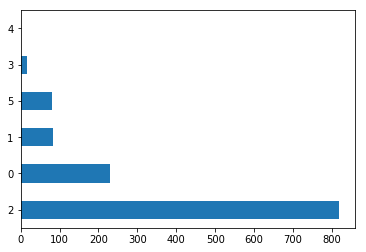

In [79]:
df_dominant_topic[df_dominant_topic["nuts"].str.contains('AT22|AT21|AT31')]['Dominant_Topic'].value_counts()[:20].plot(kind='barh')

In [70]:
df_dominant_topic[df_dominant_topic["nuts"].str.contains('AT22|AT21|AT31')]

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
635             635               2              0.9873   
636             636               2              0.9873   
637             637               2              0.9873   
638             638               2              0.9873   
639             639               2              0.9873   
640             640               2              0.9873   
641             641               2              0.9873   
642             642               2              0.9873   
643             643               2              0.9873   
644             644               2              0.9873   
645             645               2              0.9873   
646             646               2              0.9873   
1363           1363               3              0.5936   
1463           1463               9              0.9809   
1864           1864               8              0.4644   
1865           1865               8              0.4643   
2422           2422               2              0.9907   
2423           2423               2              0.9907   
2424           2424               2              0.9907   
2425           2425               2              0.9907   
3135           3135               7              0.4893   
3468           3468               2              0.9430   
3469           3469               2              0.9430   
3470           3470               2              0.9430   
3471           3471               2              0.9430   
3671           3671               8              0.5888   
3672           3672               8              0.5887   
3673           3673               8              0.5889   
3703           3703               1              0.7568   
3704           3704               1              0.7388   
...             ...             ...                 ...   
175732       175732               8              0.9841   
175789       175789               0              0.5561   
175790       175790               0              0.5562   
175791       175791               0              0.5562   
175792       175792               0              0.5562   
175793       175793               0              0.5564   
175794       175794               0              0.5561   
176262       176262               1              0.9848   
176524       176524               4              0.6336   
176909       176909               9              0.9210   
176944       176944               9              0.9662   
176945       176945               9              0.9662   
177442       177442               8              0.6473   
177443       177443               8              0.6473   
177444       177444               8              0.6473   
177445       177445               8              0.6473   
178594       178594               2              0.7792   
178595       178595               2              0.7792   
178596       178596               2              0.7792   
178597       178597               2              0.7792   
179965       179965               1              0.9898   
179966       179966               1              0.9898   
180647       180647               8              0.5140   
180648       180648               8              0.5140   
180746       180746               2              0.9890   
180747       180747               2              0.9890   
180748       180748               2              0.9890   
180749       180749               2              0.9890   
180750       180750               2              0.9890   
180751       180751               2              0.9890   

                                                 Keywords  \
635     layer, region, transistor, gate, semiconductor...   
636     layer, region, transistor, gate, semiconductor...   
637     layer, region, transistor, gate, semiconductor...   
638     layer, region, transistor, gate, semiconductor...   
639     layer, region, transistor, gate, sem

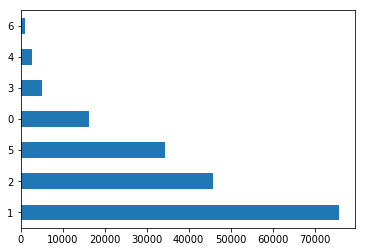

In [80]:
df_dominant_topic['Dominant_Topic'].value_counts()[:20].plot(kind='barh')

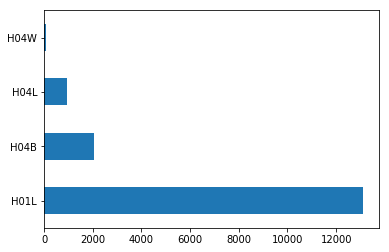

In [92]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==0]['ipcs'].value_counts()[:20].plot(kind='barh')

In [197]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==9]['nuts'].value_counts()[0:40]

AT312    1156
AT313     311
AT221      43
AT311      35
AT314      21
AT315      12
AT224      10
AT223       9
AT213       3
AT226       2
AT211       1
Name: nuts, dtype: int64

***
### Bibliography
<a id="bibl"></a>
[1] https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

[2] https://stevenloria.com/tf-idf/

[3] https://pynative.com/python-postgresql-tutorial/

[4] https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

[5] https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created

[6] https://gdcoder.com/nlp-tutorial-topic-modeling-with-svd/

[7] https://gdcoder.com/all-you-need-to-know-about-nlp-text-preprocessing/

[8] Bengfort, B., Bilbro, R., & Ojeda, T. (2018). Applied Text Analysis with Python: Enabling Language-aware Data Products with Machine Learning. " O'Reilly Media, Inc.".

[9] Bird, S., Klein, E., & Loper, E. (2009). Natural language processing with Python: analyzing text with the natural language toolkit. " O'Reilly Media, Inc.".

[10] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

[11] https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

[12] https://github.com/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

***
#### [>>> return to top](#top)